In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
# from sipbuild.generator.outputs.xml import output_xml


def load_mat(path, d=16):
    data = scipy.io.loadmat(path)['zip']
    size = data.shape[0]
    y = data[:, 0].astype('int')
    X = data[:, 1:].reshape(size, d, d)
    return X, y

def cal_intensity(X):
    """
    X: (n, d), input data
    return intensity: (n, 1)
    """
    n = X.shape[0]
    return np.mean(X.reshape(n, -1), 1, keepdims=True)

def cal_symmetry(X):
    """
    X: (n, d), input data
    return symmetry: (n, 1)
    """
    n, d = X.shape[:2]
    Xl = X[:, :, :int(d/2)]
    Xr = np.flip(X[:, :, int(d/2):], -1)
    abs_diff = np.abs(Xl-Xr)
    return np.mean(abs_diff.reshape(n, -1), 1, keepdims=True)

def cal_feature(data):
    intensity = cal_intensity(data)
    symmetry = cal_symmetry(data)
    feat = np.hstack([intensity, symmetry])

    return feat

def cal_feature_cls(data, label, cls_A=1, cls_B=5):
    """ calculate the intensity and symmetry feature of given classes
    Input:
        data: (n, d1, d2), the image data matrix
        label: (n, ), corresponding label
        cls_A: int, the first digit class
        cls_B: int, the second digit class
    Output:
        X: (n', 2), the intensity and symmetry feature corresponding to 
            class A and class B, where n'= cls_A# + cls_B#.
        y: (n', ), the corresponding label {-1, 1}. 1 stands for class A, 
            -1 stands for class B.
    """
    feat = cal_feature(data)
    indices = (label==cls_A) + (label==cls_B)
    X, y = feat[indices], label[indices]
    ind_A, ind_B = y==cls_A, y==cls_B
    y[ind_A] = 1
    y[ind_B] = -1

    return X, y

def plot_feature(feature, y, plot_num, ax=None, classes=np.arange(10)):
    """plot the feature of different classes
    Input:
        feature: (n, 2), the feature matrix.
        y: (n, ) corresponding label.
        plot_num: int, number of samples for each class to be plotted.
        ax: matplotlib.axes.Axes, the axes to be plotted on.
        classes: array(0-9), classes to be plotted.
    Output:
        ax: matplotlib.axes.Axes, plotted axes.
    """
    y[y==-1] = 5 #########
    cls_features = [feature[y==i] for i in classes]

    marks = ['s', 'o', 'D', 'v', 'p', 'h', '+', 'x', '<', '>']
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'cyan', 'orange', 'purple']
    if ax is None:
        _, ax = plt.subplots()
    for i, feat in zip(classes, cls_features):
        if len(feat) > 0:  # Ensure there are features to plot
            ax.scatter(*feat[:plot_num].T, marker=marks[i], color=colors[i], label=str(i))
    ax.legend(loc='upper right')
    plt.xlabel('intensity')
    plt.ylabel('symmetry')
    return ax

def cal_error(theta, X, y, thres=1e-4):
    """calculate the binary error of the model w given data (X, y)
    theta: (d+1, 1), the weight vector
    X: (n, d), the data matrix [X, y]
    y: (n, ), the corresponding label
    """
    out = X @ theta - thres
    pred = np.sign(out)
    err = np.mean(pred.squeeze()!=y)
    return err


# prepare data
train_data, train_label = load_mat('train_data.mat') # train_data: (7291, 16, 16), train_label: (7291, )
test_data, test_label = load_mat('test_data.mat') # test_data: (2007, 16, 16), train_label: (2007, )

cls_A, cls_B = 1, 5
X, y, = cal_feature_cls(train_data, train_label, cls_A=cls_A, cls_B=cls_B)
X_test, y_test = cal_feature_cls(test_data, test_label, cls_A=cls_A, cls_B=cls_B)


# train
iters = 2000
d = 2
num_sample = X.shape[0]
threshold = 1e-4
theta = np.zeros((d, 1))

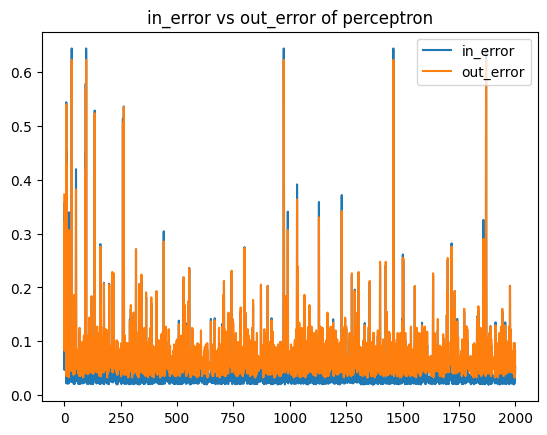

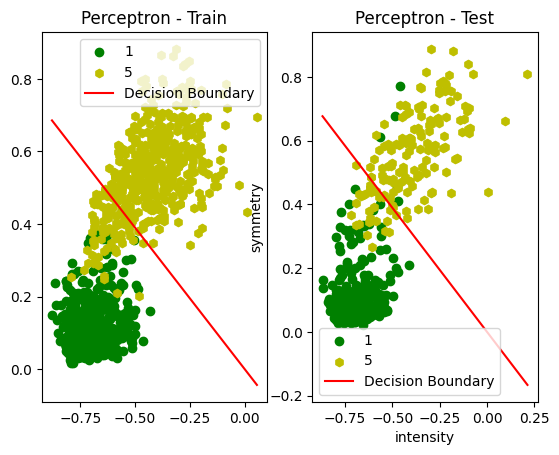

In [2]:
# perceptron
def update(theta, X, y, thres):
    out = X @ theta - thres
    pred = np.sign(out)
    wrong_X = X[pred.squeeze() != y]
    wrong_y = y[pred.squeeze() != y]
    wrong_data = np.hstack([wrong_X, wrong_y.reshape(len(wrong_y), 1)])
    chosen_index = np.random.choice(range(len(wrong_data)), size=1, replace=False)
    chosen_data = wrong_data[chosen_index, :]
    theta_new = theta + chosen_data[:, :-1].T * chosen_data[:, -1]
    return theta_new

def cal_error(theta, X, y, thres=1e-4):
    out = X @ theta - thres
    pred = np.sign(out)
    err = np.mean(pred.squeeze() != y)
    return err

def plot_decision_boundary(theta, X, y, ax):
    x_vals = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
    decision_boundary = -(theta[0, 0] / theta[1, 0]) * x_vals  
    ax.plot(x_vals, decision_boundary, color='red', label='Decision Boundary')
    ax.legend()
    
# Initialize lists to store error values
in_errors = []
out_errors = []

# Training loop
for iterate in range(iters):
    theta = update(theta, X, y, threshold)
    in_error = cal_error(theta, X, y, threshold)
    out_error = cal_error(theta, X_test, y_test, threshold)
    
    # Append errors to the lists
    in_errors.append(in_error)
    out_errors.append(out_error)

# Plot Er_in and Er_out
plt.plot(range(iters), in_errors, label="in_error")
plt.plot(range(iters), out_errors, label="out_error")
plt.title("in_error vs out_error of perceptron")
plt.legend()
plt.show()

# plot decision boundary
fig, ax = plt.subplots(1, 2)
plot_feature(X, y, 500, ax=ax[0], classes=[1, 5])
plot_decision_boundary(theta, X, y, ax=ax[0])
ax[0].set_title('Perceptron - Train')

plot_feature(X_test, y_test, 500, ax=ax[1], classes=[1, 5])
plot_decision_boundary(theta, X_test, y_test, ax=ax[1])
ax[1].set_title('Perceptron - Test')
plt.show()


In [6]:
print(y)
print(y_test)


[5 1 1 ... 1 1 1]
[1 5 5 1 1 5 1 5 1 1 1 1 5 5 5 1 5 1 5 1 1 1 1 1 1 5 1 5 1 1 1 1 1 5 5 5 1
 5 5 1 1 1 1 5 5 1 1 1 1 5 1 5 1 1 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 5 1 5 1 1 5 5 1 5 1 1 1 1 5 1 1 1 1 5 1 5 1 1 1 1 1
 5 5 5 1 1 5 5 1 1 1 5 1 5 1 5 1 5 1 1 1 1 5 1 1 1 1 1 1 1 5 1 1 1 1 1 1 5
 5 5 5 5 1 1 5 5 1 1 1 1 1 5 5 1 1 1 5 5 5 1 1 1 5 5 5 1 1 1 1 5 5 5 5 5 5
 1 5 5 5 5 5 5 5 1 1 1 1 1 1 5 5 5 1 1 1 1 1 1 1 1 5 1 5 5 1 5 1 1 5 1 1 1
 1 5 1 1 1 5 1 1 5 5 1 5 5 1 5 1 1 1 1 5 1 1 5 5 5 5 1 5 5 5 5 5 1 1 1 1 1
 5 5 1 5 5 5 1 1 1 1 1 1 1 1 1 1 5 1 1 1 5 1 1 1 1 1 5 1 1 1 1 1 1 1 1 5 1
 5 5 5 5 5 1 1 1 1 1 1 1 1 1 5 1 1 5 1 5 1 1 5 5 5 1 5 5 1 5 5 5 5 5 1 1 5
 5 1 1 1 1 1 1 1 1 5 5 1 1 1 1 1 1 1 5 5 1 1 5 5 1 1 1 1 1 5 1 1 1 5 1 1 1
 1 1 1 5 1 5 5 1 1 5 5 1 1 5 1 1 1 5 1 5 1 1 5 5 1 5 5 1 5 5 1 5 5 1 1 5 1
 5 1 5 5 5 5 5 5 5 5 1 5 5 1 5 5 1]


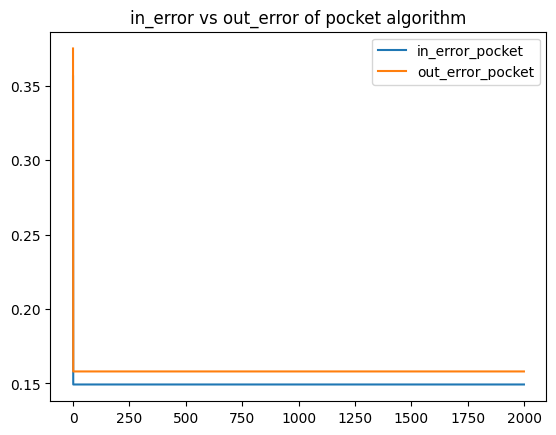

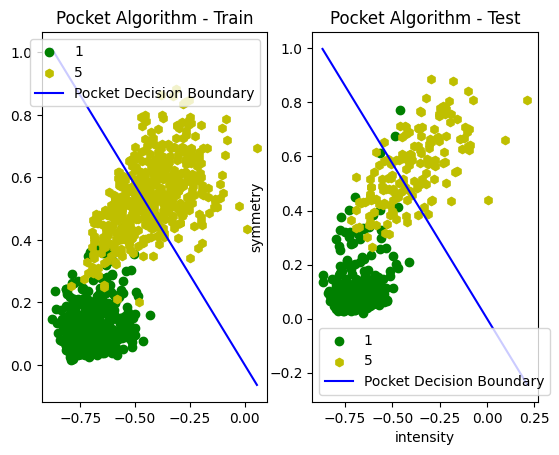

In [3]:
train_data, train_label = load_mat('train_data.mat') 
test_data, test_label = load_mat('test_data.mat') 

cls_A, cls_B = 1, 5
X, y, = cal_feature_cls(train_data, train_label, cls_A=cls_A, cls_B=cls_B)
X_test, y_test = cal_feature_cls(test_data, test_label, cls_A=cls_A, cls_B=cls_B)


iters = 2000
d = 2
num_sample = X.shape[0]
threshold = 1e-4
theta = np.zeros((d, 1))

# Pocket algorithm update function
def update_pocket(theta, X, y, thres, pocket_size):
    out = X @ theta - thres
    pred = np.sign(out)
    wrong_X = X[pred.squeeze() != y]
    wrong_y = y[pred.squeeze() != y]
    wrong_data = np.hstack([wrong_X, wrong_y.reshape(len(wrong_y), 1)])

    # Select misclassified samples
    chosen_indices = np.random.choice(range(len(wrong_data)), size=pocket_size, replace=False)
    chosen_data = wrong_data[chosen_indices, :]

    # Update weights considering samples in the pocket
    for data_point in chosen_data:
        theta_new = theta + data_point[:-1].reshape(-1, 1) * (data_point[-1]) 

    return theta_new

# calculate the error for pocket algorithm 
def cal_error_pocket(theta, X, y, thres=1e-4):
    out = X @ theta - thres
    pred = np.sign(out)
    err = np.mean(pred.squeeze() != y)
    return err

# plot the decision boundary for pocket algorithm 
def plot_decision_boundary_pocket(theta, X, y, ax):
    x_vals = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
    decision_boundary = -(theta[0, 0] / theta[1, 0]) * x_vals  
    ax.plot(x_vals, decision_boundary, color='blue', label='Pocket Decision Boundary')
    ax.legend()

# Initialize lists to store error values
in_errors = []
out_errors = []

# Training loop
pocket_num = 1  
for iterate in range(iters):
    theta_pocket = update_pocket(theta, X, y, threshold, pocket_num) 
    in_error = cal_error_pocket(theta_pocket, X, y, threshold) 
    if len(in_errors) == 0 or in_error < in_errors[-1]:
        theta = theta_pocket   
        in_errors.append(in_error)
    else:
        in_errors.append(in_errors[-1])
    out_error = cal_error_pocket(theta, X_test, y_test, threshold)
    out_errors.append(out_error)
    

# Plot Er_in and Er_out
plt.plot(range(iters), in_errors, label="in_error_pocket")
plt.plot(range(iters), out_errors, label="out_error_pocket")
plt.title("in_error vs out_error of pocket algorithm")
plt.legend()
plt.show()

# plot decision boundary
fig, ax = plt.subplots(1, 2)
plot_feature(X, y, 500, ax=ax[0], classes=[1, 5])
plot_decision_boundary_pocket(theta, X, y, ax=ax[0])
ax[0].set_title('Pocket Algorithm - Train')

plot_feature(X_test, y_test, 500, ax=ax[1], classes=[1, 5])
plot_decision_boundary_pocket(theta, X_test, y_test, ax=ax[1])
ax[1].set_title('Pocket Algorithm - Test')
plt.show()